# Scraping Analyst Opinions

In [2]:
import pandas as pd
import pymongo
import re
from re import sub
from decimal import Decimal
from pymongo import MongoClient
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pylab
import scipy
from bs4 import BeautifulSoup
import urllib

In [241]:
all_constituents = ['Allianz', 'Adidas', 'BASF', 'Bayer', 'Beiersdorf','BMW', 'Commerzbank', 'Continental', 'Daimler','Deutsche_Bank', 'Deutsche_Boerse', 'Deutsche_Post','Deutsche_Telekom', 'EON', 'Fresenius', 'HeidelbergCement', 'Infineon','Linde','Lufthansa', 'Merck', 'RWE', 'Siemens', 'Thyssenkrupp','Vonovia','Fresenius_Medical_Care','Munich_RE','ProSiebenSat1_Media','Volkswagen_vz']

## Business Insider Analyst Data

In [307]:
#Write a function that extract analyst data for all stocks
def analyst_businessinsider(constituents_list): 
    analyst_opinion_table = pd.DataFrame()
    #constituents_list = ['Adidas', 'Commerzbank', 'BMW', 'Deutsche_Bank', 'EON']
    #all_constituents = ['Allianz', 'Adidas', 'BASF', 'Bayer', 'Beiersdorf','BMW', 'Commerzbank', 'Continental', 'Daimler', 'Deutsche_Boerse', 'Deutsche_Post','Deutsche_Telekom', 'Deutsche_Bank','EON', 'Fresenius', 'HeidelbergCement', 'Infineon','Linde','Lufthansa', 'Merck', 'RWE', 'Siemens', 'thyssenkrupp','Vonovia','Fresenius_Medical_Care','Munich_RE','ProSiebenSat1_Media','Volkswagen_vz']
    #constituents_list = all_constituents
    for constituent in constituents_list:
        #print constituent
        if constituent == 'SAP':
            url = 'http://www.reuters.com/finance/stocks/analyst/SAP'
            soup = BeautifulSoup(r,'lxml')
            tables = soup.find_all('div', class_='moduleBody')
            analyst_recommendation = tables[2].find_all('td',class_='data')
            rating = float(analyst_recommendation[-4].text)     
        #print constituent
        url = 'http://markets.businessinsider.com/stock/'+constituent+'/analysts-opinions'
        r = urllib.urlopen(url).read()
        soup = BeautifulSoup(r,'lxml')
        rating_extract = soup.find_all("div",class_="rating")
        rating = float(rating_extract[0].text)
                             
        #Obtain the data inside the table as a resultset (list) and extract the text. 
        opinions = soup.find_all("td",class_=["bar buy",'bar overweight',"bar hold","bar underweight","bar sell"])
        opinions_data = [int(x.text) for x in opinions]
        buy_count=opinions_data[0]+opinions_data[1]
        hold_count=opinions_data[2]
        sell_count=opinions_data[3]+opinions_data[4]
        total = buy_count+hold_count+ sell_count
    
        #Find analyst target for stock prices
        letters = soup.find_all("table",class_='table table-small no-margin-bottom')
        letters2 = letters[0].find_all("td")
        target_list = [str(x.text.strip()) for x in letters2]

        #Extract the prices. 
        median_target = round(float(target_list[5].replace("EUR","")),2)
        highest_target = round(float(target_list[7].replace("EUR","")),2)
        lowest_target = round(float(target_list[9].replace("EUR","")),2)

                             
        #Allocate a status according to the rating
        if rating <= 2:
            rating_result='Strong buy'
        elif rating <= 2.8:
            rating_result = 'Moderate buy'
        elif rating <= 3.2:
            rating_result = 'Hold'
        elif rating <=4:
            rating_result = 'Moderate sell'
        else: 
            rating_result = 'Strong sell'
        
        analyst_opinion_table = analyst_opinion_table.append(pd.DataFrame({'Constituent':constituent,'Analyst rating': rating, 'Analyst recommendation': rating_result,'Buy':buy_count,'Hold':hold_count,'Sell':sell_count,'% Buy':round(buy_count*1.0/total,2),'% Hold':round(hold_count*1.0/total,2),'% Sell':round(sell_count*1.0/total,2),'Median target price':median_target, 'Highest target price':highest_target,'Lowest target price':lowest_target},index=[0]),ignore_index=True)
    columnsTitles = ['Constituent','Analyst rating','Analyst recommendation', 'Buy','Hold','Sell','% Buy','% Hold','% Sell','Median target price','Highest target price','Lowest target price']
    analyst_opinion_table =analyst_opinion_table.reindex(columns=columnsTitles)
    return analyst_opinion_table

In [308]:
constituents_list=['Adidas', 'Commerzbank', 'BMW', 'Deutsche_Bank', 'EON']
analyst_opinions_table=analyst_businessinsider(constituents_list)

In [260]:
analyst_opinions_table 
#analyst_opinions_table.to_csv('analyst_opinions_table.csv', encoding = 'utf-8', index = False)

,Constituent,Analyst rating,Analyst recommendation,Buy,Hold,Sell,% Buy,% Hold,% Sell,Median target price,Highest target price,Lowest target price
0,Adidas,2.4,Moderate buy,16,18,5,0.41,0.46,0.13,194.70,230.0,120.0
1,Commerzbank,2.9,Hold,5,13,3,0.24,0.62,0.14,10.25,12.8,8.5
2,BMW,2.4,Moderate buy,13,12,4,0.45,0.41,0.14,91.49,120.0,71.9
3,Deutsche_Bank,3.4,Moderate sell,5,11,12,0.18,0.39,0.43,15.31,20.0,9.5
4,EON,2.0,Strong buy,20,5,5,0.67,0.17,0.17,9.76,11.6,7.9


## Back-up websites for scraping

In [ ]:
#Collect rating for SAP in case Business Insider doesn't work. Use FT and Reuters   
url = 'https://markets.ft.com/data/equities/tearsheet/forecasts?s=DBKX.N:GER'
r = urllib.urlopen(url).read()
soup = BeautifulSoup(r,'lxml')
letters = soup.find_all('table' ,class_='mod-ui-table mod-ui-table--colored')
numbers = re.findall((r"\d+", letters[0].text))
opinions_data= [int(x) for x in numbers]
                             
#Find the highest, median and lowest targets
letters = soup.find_all('table',class_='mod-ui-table mod-ui-table--colored mod-tearsheet-forecast__table--visible')
rows = letters[0].findAll('tr')
data = [[td.findChildren(text=True) for td in tr.findAll("td")] for tr in rows]
highest_target = float(data[0][2][0])
median_target = float(data[1][2][0])
lowest_target = float(data[2][2][0])
        
#Collect the analyst rating separately
r = urllib.urlopen('http://www.reuters.com/finance/stocks/analyst/DBKGn.DE').read()
soup = BeautifulSoup(r,'lxml')
tables = soup.find_all('div', class_='moduleBody')
analyst_recommendation = tables[2].find_all('td',class_='data')
rating = float(analyst_recommendation[-4].text)     

## Visualising the Analyst Data

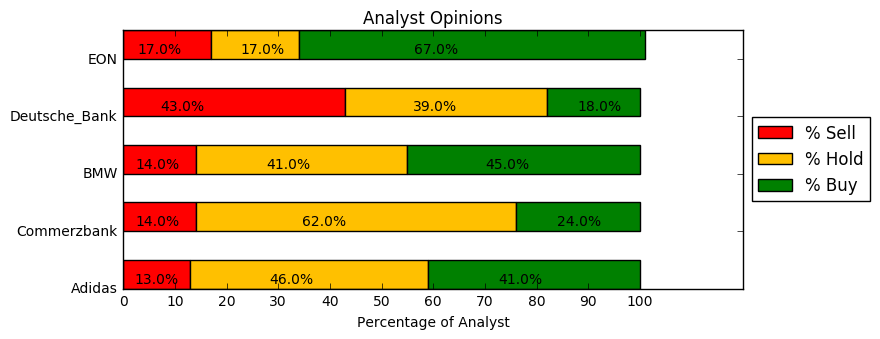

In [296]:
barh_opinions(analyst_opinions_table,ht=0.50)

In [295]:
def barh_opinions(analyst_opinions_table,ht): # the width of the bars,usually 0.35 for five selected constituents displayed
    N = len(analyst_opinions_table['Constituent'])
    buy_pct = analyst_opinions_table['% Buy']*100
    hold_pct = analyst_opinions_table['% Hold']*100
    sell_pct = analyst_opinions_table['% Sell']*100
    fig = plt.clf()
    fig,ax= plt.subplots(figsize=(8,N/1.5))
    ind = np.arange(N)    # the x locations for the groups
    p1 = ax.barh(ind, sell_pct,height=ht,color='r')
    p2 = ax.barh(ind, hold_pct,height=ht, left=sell_pct,color='#ffc000')
    p3 = ax.barh(ind, buy_pct,height=ht, left=hold_pct+sell_pct,color='g')
    
    i=0
    for p in p1.patches:
            if sell_pct.iloc[i]==0: 
                ax.annotate('', (p.get_width()/3,p.xy[1]+0.1))
            else:
                ax.annotate(str(sell_pct.iloc[i])+'%', (p.get_width()/6,p.xy[1]+0.1))
            i=i+1
    i=0
    for p in p2.patches:
        ax.annotate(str(hold_pct.iloc[i])+'%', (p.xy[0]+p.get_width()/3,p.xy[1]+0.1))
        i=i+1
    i=0
    for p in p3.patches:
        ax.annotate(str(buy_pct.iloc[i])+'%', (p.xy[0]+p.get_width()/3,p.xy[1]+0.1))
        i=i+1
    
    
    #plt.ylabel('Constituents')
    plt.xlabel('Percentage of Analyst')
    plt.title('Analyst Opinions')
    plt.yticks(ind,analyst_opinions_table['Constituent'])
    plt.xticks(np.arange(0,110,10))
    # Put a legend below current axis
    #ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, nrow=3)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])
    ax.legend((p1[0], p2[0], p3[0]), ('% Sell', '% Hold','% Buy'),loc='center left', bbox_to_anchor=(1, 0.5)) 
    
    plt.show()

In [312]:
#Presenting the target prices and analyst prediction
def opinion_scatter(constituents_list,analyst_opinions_table):
    colors = []
    for constituent in constituents_list: # keys are the names of the boys
        status = analyst_opinions_table['Analyst recommendation'].loc[analyst_opinions_table['Constituent']==constituent]
        if status.values[0] == 'Strong buy':
            colors.append('g')
        elif status.values[0] == 'Moderate buy':
            colors.append('#A9CE1D') #lime?
        elif status.values[0] == 'Hold':
            colors.append('#ffc000')
        elif status.values[0] == 'Moderate sell':
            colors.append('#FF8633')
        else:
            colors.append('r')
            
        plt.clf()
        
    X = analyst_opinions_table['Analyst rating']
    fig, ax = plt.subplots(figsize=(1,8))
    ax.scatter([1]*len(X),X, c=colors,
           marker='s', s=100)

    ax.yaxis.set_visible(True)
    ax.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

    #ax.get_yaxis().set_ticklabels(['what'])
    plt.ylim(min(X)-0.4,(max(X+0.4)))
    plt.ylabel('Rating')
    #plt.title('Analyst recommendation')
    plt.figtext(.5,.9,'Analyst Rating & Recommendation ', fontsize=12, ha='left')

    for constituent in constituents_list: 
        recommendation = analyst_opinions_table['Analyst recommendation'].loc[analyst_opinions_table['Constituent']==constituent]
        ax.annotate('%s, %s'%(constituent,recommendation.values[0]), xy=(1.1,analyst_opinions_table['Analyst rating'].loc[analyst_opinions_table['Constituent']==constituent]), textcoords='data')
        #ax.annotate('%s' , xy=(1.1,analyst_opinion_table['Analyst rating'].loc[analyst_opinion_table['Constituent']==constituent]-0.1), textcoords='data')
    #for xy in zip([1]*len(X),X):
        #print xy[1]
        #ax.annotate('%s' %xy[1], xy=xy, textcoords='data')
    
    plt.show()

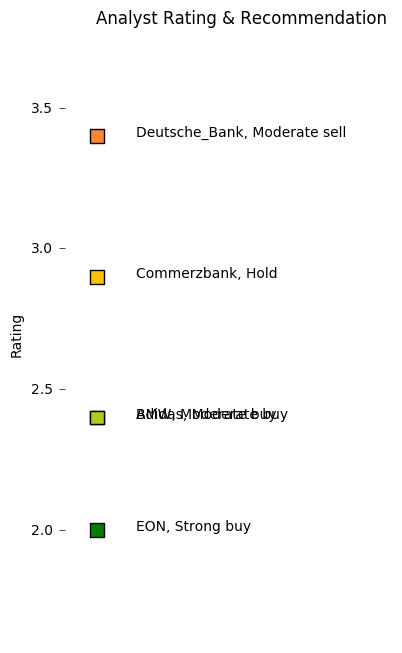

In [314]:
opinion_scatter(constituents_list,analyst_opinions_table)

# Insert Analyst rating into MongoDB